In [15]:
using Revise

In [1]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

## Define SrOH Hamiltonian and molecular states

In [2]:
μ_B = 9.2740100783e-24
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = package;
k = package.k
Γ = package.Γ
m = package.m
λ = 2π/k
;

In [3]:
energy.(package.states) .- package.states[1].E

16-element Vector{Float64}:
    0.0
 7480.522762298584
 7485.541759490967
 7490.556011199951
    5.124028577605057e7
    5.1240297798942566e7
    5.124030982210159e7
    5.2754833464767456e7
    5.2754840470775604e7
    5.275484747696304e7
    5.275485448368454e7
    5.275486148973465e7
    4.7860092421321225e14
    4.7860092421321244e14
    4.786009242132125e14
    4.786009242132126e14

In [339]:
-1.1Γ/2π / (package.states[end].E) * 3e8

-4.888491609905746

In [340]:
1.1*Γ/2π

7.04e6

## Define experimental parameters

In [58]:

## Initial condition of the molecule cloud
temp = @with_unit 100 "mK"
diameter = @with_unit 1 "mm"
displacement = [-10.0, -10.0, 0.0]*1e-3
kick = [8, 8, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -8.5*√2 ; ramp_time = 5e-3

## Laser detunings
Δ1 = -12e6
Δ3 = -12e6
Δ2 = Δ4 =Δ5= 0.0

s1 = 8
s3 = 16
s2 = s4 = s5=0.0

MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 100,
                                pol1_x=σ⁺, pol2_x=σ⁻, pol3_x=σ⁻, pol4_x=σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                RF_frequency  = 1.4e6,

                                B_gradient = B_gradient, 
                                B_grad_start = 0.0,
                                B_ramp_time = 1e-6,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 0.1,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance = 0.0, 
                                s_imbalance = (0.0, -0.0, -0.), retro_loss=0., 
                                off_center=[4, -4, -0, 4, 0, 0].*1e-3 .* 0, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =0.02)
;

In [57]:
# results_5 = results;

## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [59]:
MOT_params.n_values = 60
sequence = [MOT_params]
durations = [5e-3]
generate_sequence!(sequence, durations);
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);

Progress: 100%|█████████████████████████████████████████| Time: 0:08:18


498.637777 seconds (15.77 G allocations: 360.657 GiB, 10.88% gc time)


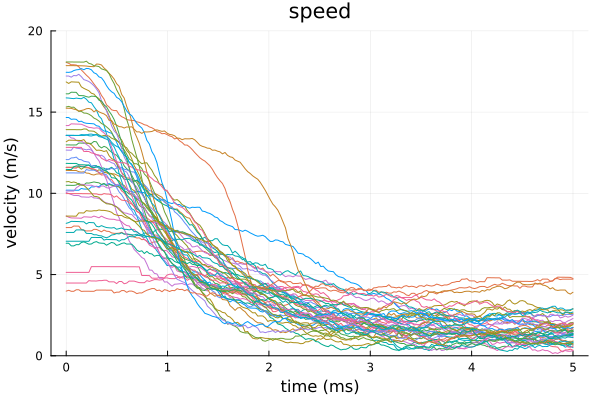

In [65]:
plot_survival_velocities(results,"all")
plot!(ylim=(0,20))

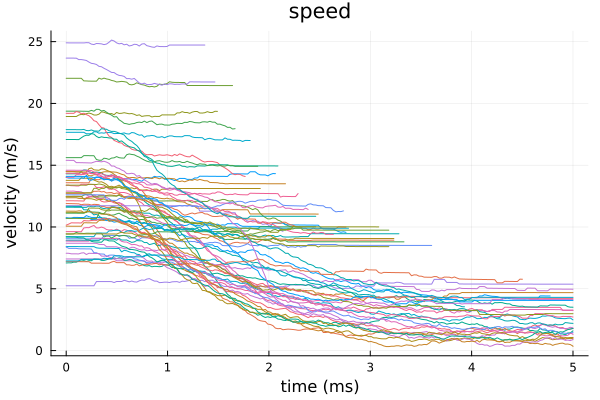

In [68]:
plot_all_velocities(results_5,"all")
plot!()

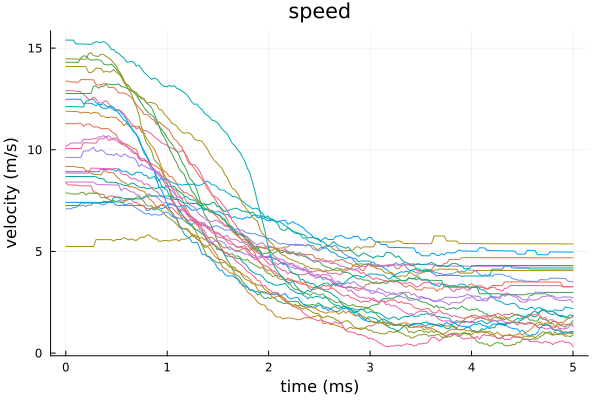

In [62]:
plot_survival_velocities(results_5,"all")
plot!()f

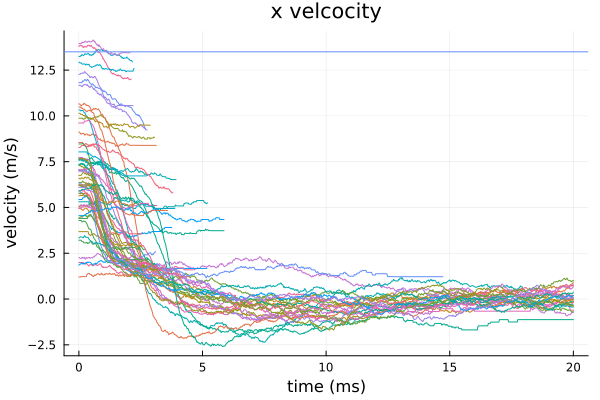

In [393]:
plot_all_velocities(results_1,"x")
hline!([13.5])
plot!()

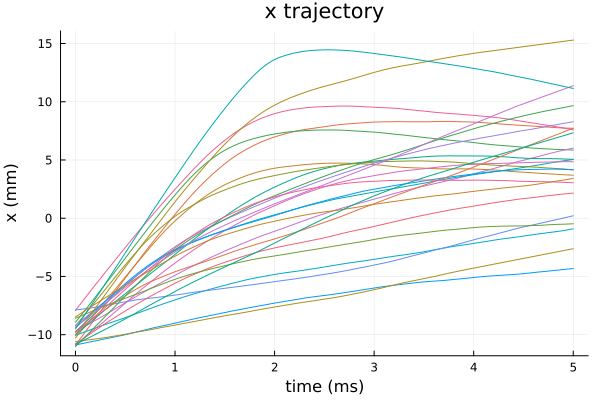

In [67]:
plot_survival_trajectories(results_5,"x")
plot!()

In [397]:
trapped_is = get_trapped_indicies(MOT_params, results_3)
@printf("%i out of %i molecules trapped.", length(trapped_is), MOT_params.n_values)

43 out of 60 molecules trapped.

In [448]:
results = results_3;

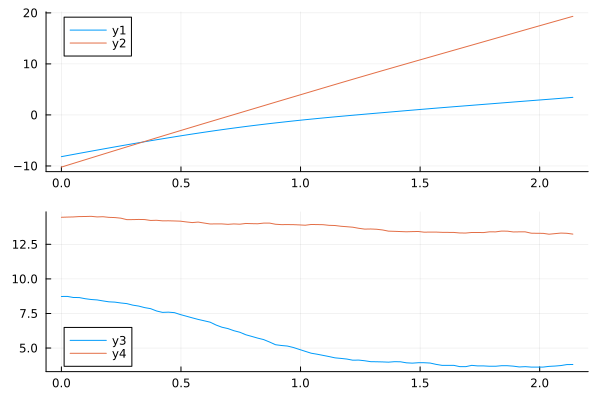

In [454]:
i += 1
plot(layout=(2,1))
plot!(results.times[i], results.x_trajectories[i],subplot=1)
plot!(results.times[i], results.y_trajectories[i],subplot=1)
plot!(results.times[i], results.x_velocities[i],subplot=2)
plot!(results.times[i], results.y_velocities[i],subplot=2)

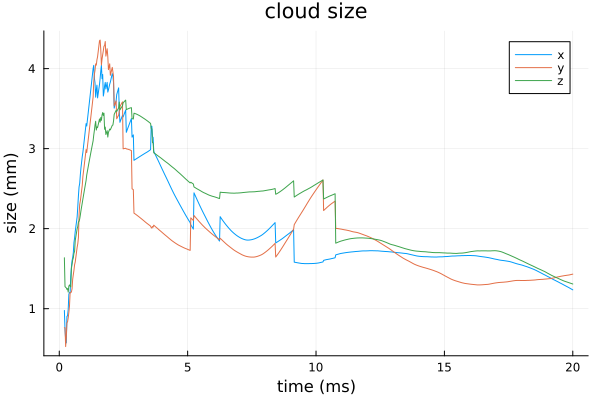

In [418]:
plot_size(results,"all")
plot!()

0.4683298655794734


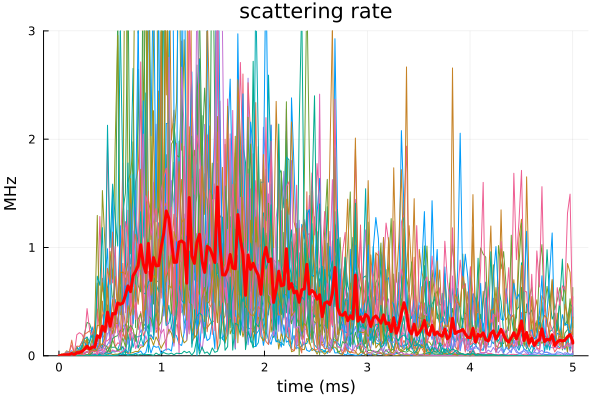

In [63]:
println(plot_survival_scattering_rate(MOT_params, results_5))
plot!(ylim=[0,3])
# println(plot_photons_scattered(results))

2325.44
0.13615706746575018


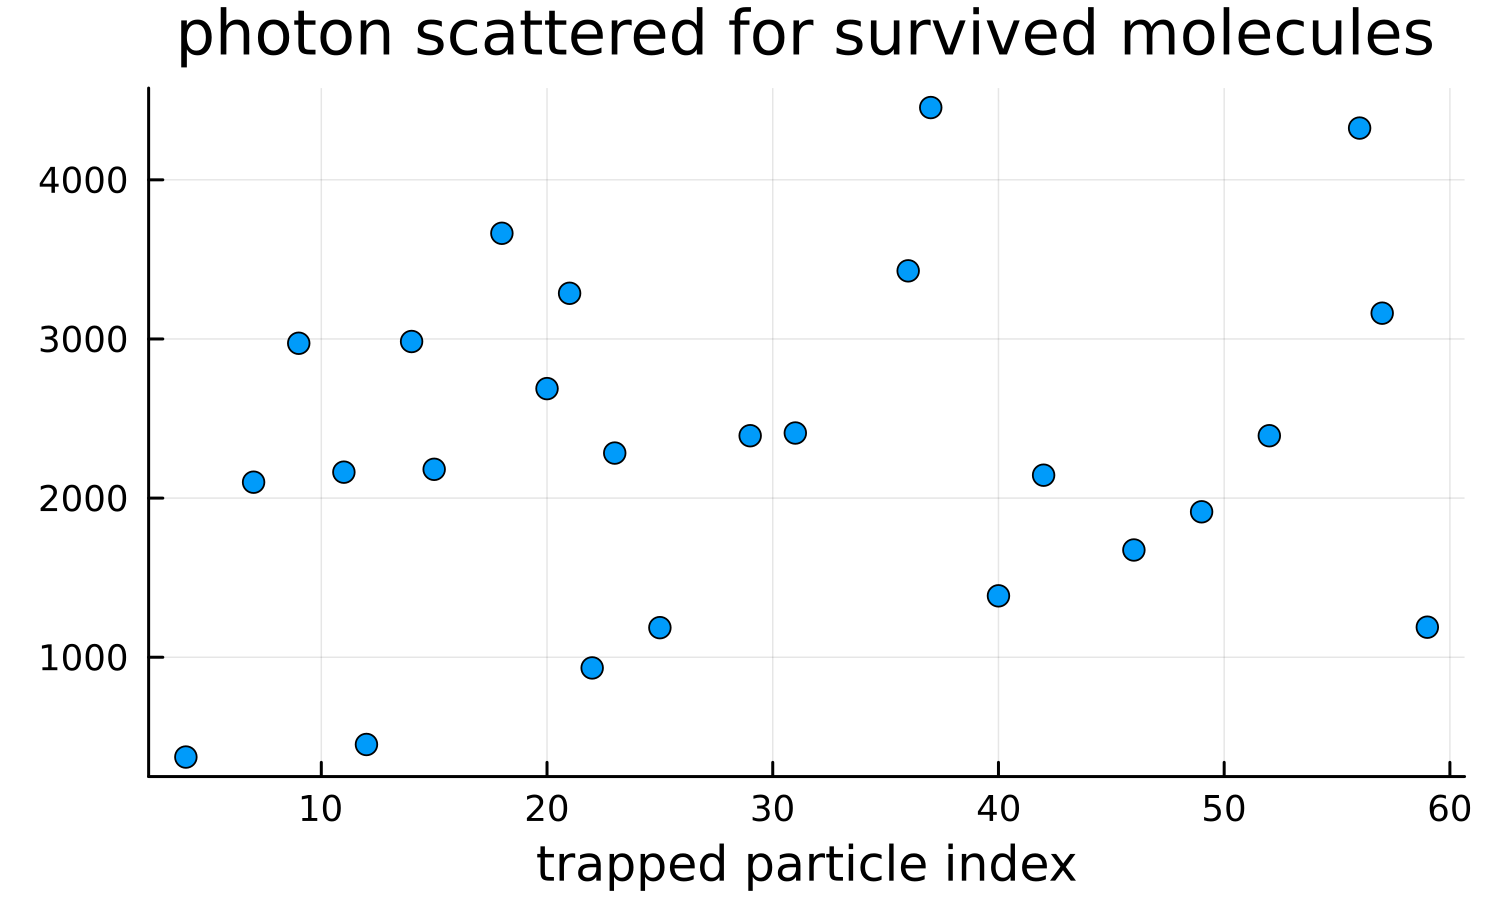

In [55]:
println(plot_photons_scattered(results))
println(scattering_rate_at_t(results, 5))
plot!()

In [4]:
using
    DifferentialEquations,
    LinearAlgebra
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using Parameters

import ProgressMeter: Progress, next!

import OpticalBlochEquations.simulate_particles_constant_diffusion

function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx 
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time 
    scalar_ramp = min(t/τ_bfield, 1.0) 
    scalar_RF = cos(p.sim_params.RF_frequency * t + π/2)

    B_grad = p.sim_params.B_gradient * scalar_ramp + p.sim_params.B_grad_start
    
    gradient_x = +(scalar_RF * B_grad) * 1e2 / k/2
    gradient_y = +(scalar_RF * B_grad) * 1e2 / k/2
    gradient_z = -(scalar_RF * B_grad) * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    # Update the Hamiltonian for the molecule-ODT interaction
    H_ODT = p.extra_data.H_ODT_static
    
    ODT_size = p.sim_params.ODT_size .* p.k
    update_ODT_center!(p, t)
    ODT_x = p.extra_data.ODT_position[1] * p.k
    ODT_z = p.extra_data.ODT_position[2] * p.k
    
    scalar_ODT = exp(-2(r[1]-ODT_x)^2/ODT_size[1]^2) * exp(-2r[2]^2/ODT_size[2]^2) * exp(-2(r[3]-ODT_z)^2/ODT_size[3]^2)
    
    @turbo for i in eachindex(H)
        H.re[i] += H_ODT.re[i] * scalar_ODT
        H.im[i] += H_ODT.im[i] * scalar_ODT
    end
    
    # return SVector{3,ComplexF64}(0,0,0)
    return SVector{3,ComplexF64}((-4(r[1]-ODT_x) / ODT_size[1]^2) * scalar_ODT, (-4r[2] / ODT_size[2]^2) * scalar_ODT, (-4(r[3]-ODT_z) / ODT_size[3]^2) * scalar_ODT)
    
end

function make_problem_with_param_constant_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k 

    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick

    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss

    RF_frequency = param.RF_frequency* 2π / Γ
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1],m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2],m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3],m)

  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
   photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        B_grad_start = param.B_grad_start,
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,
        
        s_total = s1 + s2 + s3 + s4,
        diffusion_constant = param.diffusion_constant,
        RF_frequency = RF_frequency
        )

    t_span = (t_start, t_end) ./ (1/Γ);
    
    ω1 = 2π * (states[end].E - states[1].E) + Δ1 * 2π
    ω2 = 2π * (states[end].E - states[1].E)  + Δ2 * 2π
    ω3 = 2π * (states[end].E - states[6].E)  + Δ3 * 2π
    ω4 = 2π * (states[end].E - states[6].E)  + Δ4 * 2π

    # ϵ_(ϵ, f) = t -> ϵ
    ϵ_(ϵ1, ϵ2) = t -> iseven(t ÷ (π/RF_frequency)) ? ϵ1 : ϵ2
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    # s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> (s*factor + (s - s*factor) * exp(-t/ramp_time)) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1.0#1/2-rand()
    sy_rand = 1.0#1/2-rand()
    sz_rand = 1.0#1/2-rand()

    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ =  kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ1f = ϕs[1]*rotate_pol(pol1_x, -k̂); ϵ_func1 = ϵ_(ϵ1, ϵ1f); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ2f = ϕs[2]*rotate_pol(pol1_x, -k̂); ϵ_func2 = ϵ_(ϵ2, ϵ2f); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ =  ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ3f = ϕs[3]*rotate_pol(pol1_x, -k̂); ϵ_func3 = ϵ_(ϵ3, ϵ3f); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ4f = ϕs[4]*rotate_pol(pol1_x, -k̂); ϵ_func4 = ϵ_(ϵ4, ϵ4f); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ =  kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ5f = ϕs[5]*rotate_pol(flip(pol1_x), -k̂); ϵ_func5 = ϵ_(ϵ5, ϵ5f); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ6f = ϕs[6]*rotate_pol(flip(pol1_x), -k̂); ϵ_func6 = ϵ_(ϵ6, ϵ6f); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ =  kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ7f = ϕs[1]*rotate_pol(pol2_x, -k̂); ϵ_func7 = ϵ_(ϵ7, ϵ7f); laser7 = Field(k̂, ϵ_func7, ω2,  s_gaussian_ramp(s2x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ8f = ϕs[2]*rotate_pol(pol2_x, -k̂); ϵ_func8 = ϵ_(ϵ8, ϵ8f); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ =  ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ9f = ϕs[3]*rotate_pol(pol2_x, -k̂); ϵ_func9 = ϵ_(ϵ9, ϵ9f); laser9 = Field(k̂, ϵ_func9, ω2,  s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ10f = ϕs[4]*rotate_pol(pol2_x, -k̂); ϵ_func10 = ϵ_(ϵ10, ϵ10f); laser10 = Field(k̂, ϵ_func10, ω2,  s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ =  kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ11f = ϕs[5]*rotate_pol(flip(pol2_x), -k̂); ϵ_func11 = ϵ_(ϵ11, ϵ11f); laser11 = Field(k̂, ϵ_func11, ω2,  s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ12f = ϕs[6]*rotate_pol(flip(pol2_x), -k̂); ϵ_func12 = ϵ_(ϵ12, ϵ12f); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ13f = ϕs[1]*rotate_pol(pol3_x, -k̂); ϵ_func13 = ϵ_(ϵ13, ϵ13f); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ14f = ϕs[2]*rotate_pol(pol3_x, -k̂); ϵ_func14 = ϵ_(ϵ14, ϵ14f); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ15f = ϕs[3]*rotate_pol(pol3_x, -k̂); ϵ_func15 = ϵ_(ϵ15, ϵ15f); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ16f = ϕs[4]*rotate_pol(pol3_x, -k̂); ϵ_func16 = ϵ_(ϵ16, ϵ16f); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ17f = ϕs[5]*rotate_pol(pol3_x, -k̂); ϵ_func17 = ϵ_(ϵ17, ϵ17f); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ18f = ϕs[6]*rotate_pol(pol3_x, -k̂); ϵ_func18 = ϵ_(ϵ18, ϵ18f); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ19f = ϕs[1]*rotate_pol(pol4_x, -k̂); ϵ_func19 = ϵ_(ϵ19, ϵ19f); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ20f = ϕs[2]*rotate_pol(pol4_x, -k̂); ϵ_func20 = ϵ_(ϵ20, ϵ20f); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ21f = ϕs[3]*rotate_pol(pol4_x, -k̂); ϵ_func21 = ϵ_(ϵ21, ϵ21f); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ22f = ϕs[4]*rotate_pol(pol4_x, -k̂); ϵ_func22 = ϵ_(ϵ22, ϵ22f); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ23f = ϕs[5]*rotate_pol(pol4_x, -k̂); ϵ_func23 = ϵ_(ϵ23, ϵ23f); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ24f = ϕs[6]*rotate_pol(pol4_x, -k̂); ϵ_func24 = ϵ_(ϵ24, ϵ24f); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
        
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end
               
    return prob
end

function simulate_particles_constant_diffusion(package, package_A, sequence_of_params)
    
    n_values = sequence_of_params[1].n_values
    n_threads=Threads.nthreads()
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    prog_bar = Progress(n_values)

    n_states = length(package.states)
    n_excited = package.n_excited

    x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    x_velocities = Array{Vector{Float64}}(fill([],n_values))
    y_velocities = Array{Vector{Float64}}(fill([],n_values))
    z_velocities = Array{Vector{Float64}}(fill([],n_values))
    A_populations = Array{Vector{Float64}}(fill([],n_values))
    times = Array{Vector{Float64}}(fill([],n_values))
    photons_scattered = zeros(n_values)

                            
    results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
                                x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
                                times=times, A_populations=A_populations,
                                n_values=n_values, photons_scattered=photons_scattered, n_states = n_states, n_excited=n_excited,
                                Γ = package.Γ, k=package.k)

    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))

    Threads.@threads for i ∈ 1:n_threads
    
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)

        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1) 
            ψ0 = nothing
            for i_param in 1:length(sequence_of_params)
                randomize = false
                if i_param == 1
                     randomize = true
                end
                params = sequence_of_params[i_param]      
                prob_copy = make_problem_with_param_constant_diffusion(package, package_A, params, randomize_initial_vector = randomize, ψ0=ψ0)
                ψ0 = continue_particle_constant_diffusion!(j, results, prob_copy)    
                if abs(params.t_end - results.times[j][end]*1e-3) > 1e-3
                          break # this particle has already died
                end
            end

            next!(prog_bar)
        end
    end
    
    return results
end

import OpticalBlochEquations.condition
function condition(u,t,integrator)
    p = integrator.p
    integrated_excited_pop = 0.0
    for i ∈ 1:p.n_excited
        integrated_excited_pop += real(u[p.n_states+i])
    end
    
    _condition = integrated_excited_pop - p.time_to_decay
    
    r = 0.0
    for i ∈ 1:3
        r += norm(u[p.n_states + p.n_excited + i])^2
    end
    r = sqrt(r)
    if r >= 20e-3*k # terminate if the particle is more than 1.5 mm from the centre
       terminate!(integrator) 
    elseif integrator.p.n_scatters > integrator.p.sim_params.photon_budget # also terminate if too many photons have been scattered
        terminate!(integrator)
    end
    return _condition
end

import OpticalBlochEquations.gaussian_intensity_along_axes
function gaussian_intensity_along_axes(r, axes, centers, k)
"""1/e^2 width = 5mm Gaussian beam """
d2 = (r[axes[1]] - centers[1])^2 + (r[axes[2]] - centers[2])^2   
return exp(-2*d2/(5e-3/(1/k))^2)
end

gaussian_intensity_along_axes (generic function with 1 method)

In [ ]:
gaussian_intensity_along_axes(10e-3, )